# Testing the Simplified Betts-Miller scheme in a 2D model

The scheme is described by [Frierson (2007), J. Atmos. Sci. 64, doi:10.1175/JAS3935.1](https://doi.org/10.1175/JAS3935.1).

This is a work in progress to wrap the Fortran code from Dargan Frierson into a climlab process.

In this notebook, I set up a 2D zonally averaged model with the following processes:

- Annual mean insolation
- Longwave and Shortwave radiation
- Surface turbulent fluxes of sensible and latent heat
- Moist convection

## Building from source

For now, this what you have to do to install and use the code. First, get yourself a copy of the [source repo on github](https://github.com/brian-rose/climlab-sbm-convection). Then do the following.

### Build environment

Here are instructions to create a build environment (including Fortran compiler) with conda/mamba

Starting from the root of the `climlab-sbm-convection` repo *(example for Apple M1 machine, see `./ci/` for other environment files)*:
```
mamba create --name sbm_build_env python=3.10 --channel conda-forge
mamba env update --file ./ci/requirements-macos-arm64.yml
conda activate sbm_build_env
```

### Building with f2py

From the root of the repository, do this:
```
f2py -c -m _simplified_betts_miller climlab_betts_miller.f90
```

This will create the shared object `_simplified_betts_miller.cpython-*.so` that can be imported in a Python session.

_This is a work in progress, and eventually there will be better packaging so this manual build step will not be needed._

### Runtime environment for this notebook

See [here](https://github.com/brian-rose/ClimateLaboratoryBook/blob/main/environment.yml) for a conda environment file that specifies everything needed for this notebook.

In [1]:
import climlab
from simplified_betts_miller import SimplifiedBettsMiller
import numpy as np
import matplotlib.pyplot as plt

/Users/br546577/miniconda3/envs/climlab-courseware/lib/python3.10/site-packages/climlab/convection/akmaev_adjustment.py:142: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  Akmaev_adjustment = jit(signature_or_function=Akmaev_adjustment)


In [2]:
# A two-dimensional domain
num_lev = 30
num_lat = 60
full_state = climlab.column_state(num_lev=num_lev, num_lat=num_lat, water_depth=10.)
lev = full_state.Tatm.domain.axes['lev'].points
qStrat = 5.E-6

# Use Manabe's profile as an initial condition for specific humidity
Q = full_state['Tatm'].domain.axes['lev'].points / climlab.utils.constants.ps
RHprofile = 0.7 * ((Q-0.02) / (1-0.02))
e = climlab.utils.thermo.clausius_clapeyron(full_state['Tatm']) * RHprofile
qStrat = 5.E-6
qinitial = np.maximum(qStrat, e/full_state['Tatm'].domain.axes['lev'].points * climlab.utils.constants.Rd / climlab.utils.constants.Rv)
#qinitial = 0.*full_state.Tatm + qStrat

full_state['q'] = qinitial
temperature_state = {'Tatm':full_state.Tatm,'Ts':full_state.Ts}
surface_state = {'Ts': full_state.Ts}

In [3]:
short_timestep=climlab.utils.constants.seconds_per_hour
long_timestep = short_timestep*24

#  Annual mean insolation as a function of latitude and time of year
sun = climlab.radiation.AnnualMeanInsolation(name='Insolation',
                                             domains=full_state['Ts'].domain,
                                             timestep=long_timestep,
                                            )

#  Convection scheme -- water vapor is a state variable
conv = SimplifiedBettsMiller(name='Convection',
                             state=full_state,
                             timestep=short_timestep,  # SBM convection scheme seems to require a short timestep to avoid some instabilities
                            )  
#  Couple the radiation to insolation and water vapor processes
rad = climlab.radiation.RRTMG(name='Radiation',
                              state=temperature_state, 
                              specific_humidity=full_state['q'], 
                              albedo=0.125,
                              insolation=sun.insolation,
                              coszen=sun.coszen,
                              timestep=long_timestep,
                              )
atm = climlab.couple([rad, conv], name='Atmosphere')

shf = climlab.surface.SensibleHeatFlux(name='SHF',
                                       state=temperature_state, 
                                       Cd=0.5E-3, 
                                       timestep=long_timestep,)
lhf = climlab.surface.LatentHeatFlux(name='LHF',
                                     state=full_state, 
                                     Cd=0.5E-3, 
                                     timestep=long_timestep,)
# diff = climlab.dynamics.MeridionalHeatDiffusion(name='Ocean heat transport',
#                                                 state=surface_state, 
#                                                 D=0.555, 
#                                                 timestep=timestep)

#surface = climlab.couple([shf,lhf,diff], name="Slab")
surface = climlab.couple([shf,lhf], name="Slab")

moistmodel = climlab.couple([sun,atm,surface], name='2D Radiative-Convective model')

print(moistmodel)

climlab Process of type <class 'climlab.process.time_dependent_process.TimeDependentProcess'>. 
State variables and domain shapes: 
  Tatm: (60, 30) 
  Ts: (60, 1) 
  q: (60, 30) 
The subprocess tree: 
2D Radiative-Convective model: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
   Insolation: <class 'climlab.radiation.insolation.AnnualMeanInsolation'>
   Atmosphere: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
      Radiation: <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>
         SW: <class 'climlab.radiation.rrtm.rrtmg_sw.RRTMG_SW'>
         LW: <class 'climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW'>
      Convection: <class 'simplified_betts_miller.SimplifiedBettsMiller'>
   Slab: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
      SHF: <class 'climlab.surface.turbulent.SensibleHeatFlux'>
      LHF: <class 'climlab.surface.turbulent.LatentHeatFlux'>



/Users/br546577/miniconda3/envs/climlab-courseware/lib/python3.10/site-packages/climlab/radiation/radiation.py:156: UserWarning: Some grid points are beyond the bounds of the ozone file. Ozone values will be extrapolated.
  warnings.warn('Some grid points are beyond the bounds of the ozone file. Ozone values will be extrapolated.')


In [4]:
moistmodel.step_forward()

In [5]:
def plot_state(model):
    fig, ax = plt.subplots()
    model.Tatm.to_xarray().plot(x='lat',y='lev', yincrease=False)
    CS = model.q.to_xarray().plot.contour(x='lat',y='lev', yincrease=False)
    ax.clabel(CS)
    return fig, ax

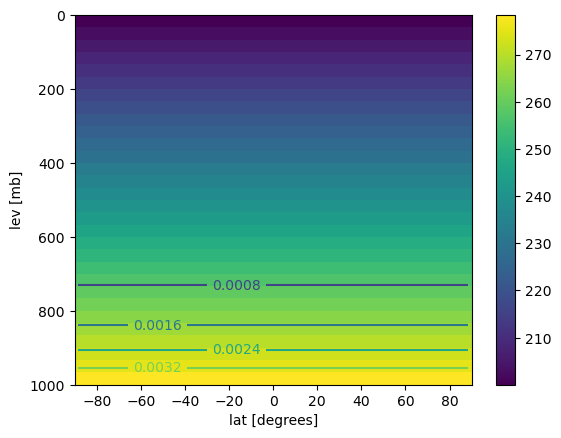

In [6]:
fig, ax = plot_state(moistmodel)

In [7]:
moistmodel.integrate_days(10)

Integrating for 239 steps, 10.0 days, or 0.027379092558307883 years.
Total elapsed time is 0.027379092558307862 years.


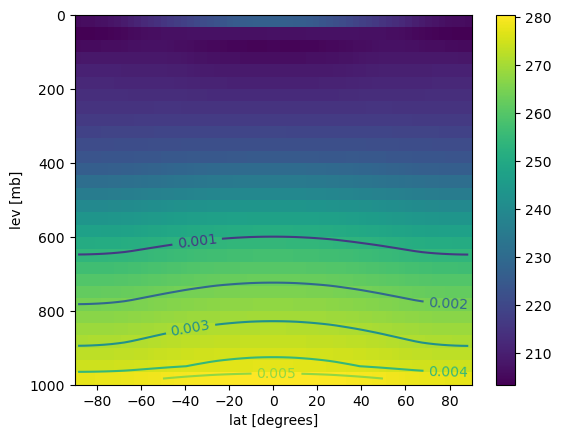

In [8]:
fig, ax = plot_state(moistmodel)

In [9]:
moistmodel.integrate_years(1)

Integrating for 8765 steps, 365.2422 days, or 1 years.
Total elapsed time is 1.0272863686982616 years.


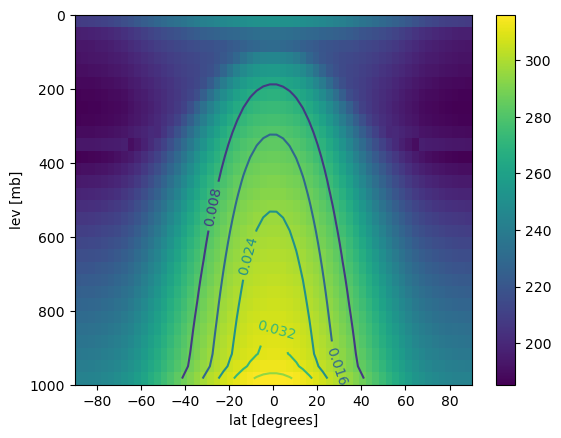

In [10]:
fig, ax = plot_state(moistmodel)

Here we can see the spatial structure of air temperature and specific humidity emerging from the interaction of insolation, radiation, surface fluxes, and the moist convection scheme.

This model has no meridional heat transport, so develops a very hot equator and cold pole.

In [11]:
moistmodel.integrate_years(1)

Integrating for 8765 steps, 365.2422 days, or 1 years.
Total elapsed time is 2.027193644837732 years.


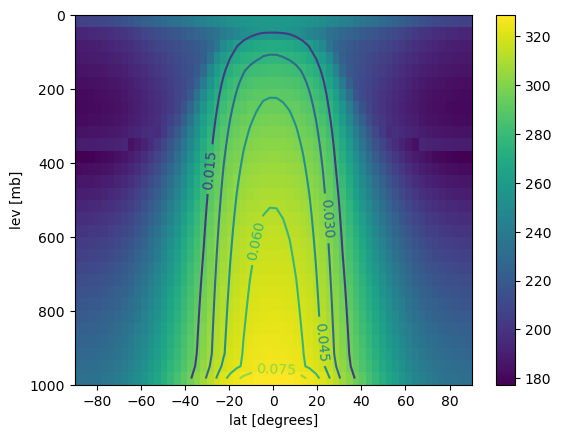

In [12]:
fig, ax = plot_state(moistmodel)

After another year of integration, the hot tropics / cold pole pattern becomes even clearer.

In [13]:
moistmodel.integrate_years(1)

Integrating for 8765 steps, 365.2422 days, or 1 years.
Total elapsed time is 3.0271009209773014 years.


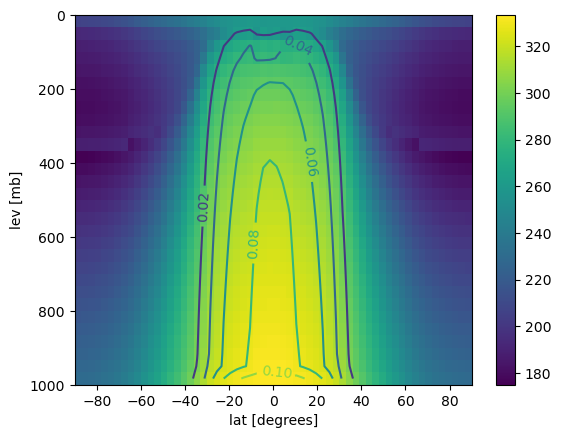

In [14]:
fig, ax = plot_state(moistmodel)